# Compilation
Compile destination C file.  
Input: name of file without extension format
Output: finished / failed

In [1]:
import os
import sys
def compileCode(filename):
    os.system('gcc source_princetonlibgloballib/'+filename+'.c -lm -o '+filename)
    after_name = filename+".exe"
    print("Blackbox Model Name: ",filename)
    if(os.path.exists(after_name)):
        print("Compilation finished")
    else:
        print("Compilation failed")

# Read boundaries, starting points and number of variables
Read parameters from files in problemdata/ directory  
input: data file name without extension format
output: number of variables, lower bound, upper bound and starting point

In [2]:
def read_datafile(filename):
    numOfVar = 0
    lowBound = []
    upBound = []
    startPoint = []
    
    infile = open("problemdata/"+filename+".problem.data",'r')
    lines = infile.readlines()
    # The first line
    for num in lines[0].split():
        numOfVar = int(num.strip())
    # The second line
    for i in lines[1].split():
        lowBound.append(float(i.strip()))
    # The third line
    for j in lines[2].split():
        upBound.append(float(j.strip()))
    # The fourth line
    for k in lines[3].split():
        startPoint.append(float(k.strip()))
    infile.close()
    print("Number of Variables: ",numOfVar)
    print("Lower Boundary: ",lowBound)
    print("Upper Boundary: ",upBound)
    print("Starting point is: ",startPoint)
    return numOfVar,lowBound,upBound,startPoint

# Sampling
## Hammersley sequence
Generate input values according to Hammersley sequence which is a classical low discrepency sequence making points spread evenly in multi-dimentional space  
@Parameters:  
Input, integer I, the index of the element of the sequence.  0 <= I.    
Input, integer M, the spatial dimension.  1 <= M <= 100.  
Input, integer N, the "base" for the first component.   1 <= N.  
Output, real R(M), the element of the sequence with index I.

In [3]:
import numpy as np
def hammersley (i,m=1,n=16):
    i = int ( i )
    t = np.ones ( m - 1 )
    t = i * t
#
#  Carry out the computation.
#
    prime_inv = np.zeros ( m - 1 )
    for j in range ( 0, m - 1 ):
        prime_inv[j] = 1.0 / float ( prime ( j ) )
    r = np.zeros ( m )
    r[0] = float ( i % ( n + 1 ) ) / float ( n )
    while ( 0 < np.sum ( t ) ):
        for j in range ( 0, m - 1 ):
            d = ( t[j] % prime ( j ) )
            r[j+1] = r[j+1] + float ( d ) * prime_inv[j]
            prime_inv[j] = prime_inv[j] / prime ( j )
            t[j] = ( t[j] // prime ( j ) )
    return r

def hammersley_seq_format(lBound,uBound,points=16):
    ratio = (uBound - lBound) / 1.0
    seq = []
    for i in range(0,points+1):
        val = hammersley(i)[0]*ratio + lBound
        seq.append(val)
    return seq

## Van der Corput sequence

In [21]:
def van_der_corput(lBound,uBound,n_sample, base=2):
    """Van der Corput sequence.
    :param int n_sample: number of element of the sequence.
    :param int base: base of the sequence.
    :return: sequence of Van der Corput.
    :rtype: list (n_samples,)
    """
    sequence = []
    ratio = (uBound - lBound) / 1.0
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number*ratio+lBound)

    return sequence

## The Halton Quasi Monte Carlo (QMC) Sequence

Parameters:
    Input, integer I, the index of the element of the sequence.  
    0 <= I.  
    Input, integer M, the spatial dimension.  
    1 <= M <= 1600.  
    Output, real R(M), the element of the sequence with index I.

In [50]:
import numpy as np
def halton_sequence(lowerBound,upperBound,i):
    ratio = (upperBound - lowerBound)/1.0
    seq = [(halton(num)[0]*ratio+lowerBound) for num in range(i)]
    return seq

def halton (i, m=1):
    i = int (i)
    t = np.ones ( m )
    t = i * t
    prime_inv = np.zeros ( m )
    for j in range ( 0, m ):
        prime_inv[j] = 1.0 / float ( prime ( j ) )

    r = np.zeros ( m )

    while ( 0 < np.sum ( t ) ):
        for j in range ( 0, m ):
            d = ( t[j] % prime ( j ) )
            r[j] = r[j] + float ( d ) * prime_inv[j]
            prime_inv[j] = prime_inv[j] / prime ( j )
            t[j] = ( t[j] // prime ( j ) )
    return r
def prime ( n ):
    import numpy as np
    prime_max = 1600

    prime_vector = np.array ( [
        2,    3,    5,    7,   11,   13,   17,   19,   23,   29, \
       31,   37,   41,   43,   47,   53,   59,   61,   67,   71, \
       73,   79,   83,   89,   97,  101,  103,  107,  109,  113, \
      127,  131,  137,  139,  149,  151,  157,  163,  167,  173, \
      179,  181,  191,  193,  197,  199,  211,  223,  227,  229, \
      233,  239,  241,  251,  257,  263,  269,  271,  277,  281, \
      283,  293,  307,  311,  313,  317,  331,  337,  347,  349, \
      353,  359,  367,  373,  379,  383,  389,  397,  401,  409, \
      419,  421,  431,  433,  439,  443,  449,  457,  461,  463, \
      467,  479,  487,  491,  499,  503,  509,  521,  523,  541, \
      547,  557,  563,  569,  571,  577,  587,  593,  599,  601, \
      607,  613,  617,  619,  631,  641,  643,  647,  653,  659, \
      661,  673,  677,  683,  691,  701,  709,  719,  727,  733, \
      739,  743,  751,  757,  761,  769,  773,  787,  797,  809, \
      811,  821,  823,  827,  829,  839,  853,  857,  859,  863, \
      877,  881,  883,  887,  907,  911,  919,  929,  937,  941, \
      947,  953,  967,  971,  977,  983,  991,  997, 1009, 1013, \
     1019, 1021, 1031, 1033, 1039, 1049, 1051, 1061, 1063, 1069, \
     1087, 1091, 1093, 1097, 1103, 1109, 1117, 1123, 1129, 1151, \
     1153, 1163, 1171, 1181, 1187, 1193, 1201, 1213, 1217, 1223, \
     1229, 1231, 1237, 1249, 1259, 1277, 1279, 1283, 1289, 1291, \
     1297, 1301, 1303, 1307, 1319, 1321, 1327, 1361, 1367, 1373, \
     1381, 1399, 1409, 1423, 1427, 1429, 1433, 1439, 1447, 1451, \
     1453, 1459, 1471, 1481, 1483, 1487, 1489, 1493, 1499, 1511, \
     1523, 1531, 1543, 1549, 1553, 1559, 1567, 1571, 1579, 1583, \
     1597, 1601, 1607, 1609, 1613, 1619, 1621, 1627, 1637, 1657, \
     1663, 1667, 1669, 1693, 1697, 1699, 1709, 1721, 1723, 1733, \
     1741, 1747, 1753, 1759, 1777, 1783, 1787, 1789, 1801, 1811, \
     1823, 1831, 1847, 1861, 1867, 1871, 1873, 1877, 1879, 1889, \
     1901, 1907, 1913, 1931, 1933, 1949, 1951, 1973, 1979, 1987, \
     1993, 1997, 1999, 2003, 2011, 2017, 2027, 2029, 2039, 2053, \
     2063, 2069, 2081, 2083, 2087, 2089, 2099, 2111, 2113, 2129, \
     2131, 2137, 2141, 2143, 2153, 2161, 2179, 2203, 2207, 2213, \
     2221, 2237, 2239, 2243, 2251, 2267, 2269, 2273, 2281, 2287, \
     2293, 2297, 2309, 2311, 2333, 2339, 2341, 2347, 2351, 2357, \
     2371, 2377, 2381, 2383, 2389, 2393, 2399, 2411, 2417, 2423, \
     2437, 2441, 2447, 2459, 2467, 2473, 2477, 2503, 2521, 2531, \
     2539, 2543, 2549, 2551, 2557, 2579, 2591, 2593, 2609, 2617, \
     2621, 2633, 2647, 2657, 2659, 2663, 2671, 2677, 2683, 2687, \
     2689, 2693, 2699, 2707, 2711, 2713, 2719, 2729, 2731, 2741, \
     2749, 2753, 2767, 2777, 2789, 2791, 2797, 2801, 2803, 2819, \
     2833, 2837, 2843, 2851, 2857, 2861, 2879, 2887, 2897, 2903, \
     2909, 2917, 2927, 2939, 2953, 2957, 2963, 2969, 2971, 2999, \
     3001, 3011, 3019, 3023, 3037, 3041, 3049, 3061, 3067, 3079, \
     3083, 3089, 3109, 3119, 3121, 3137, 3163, 3167, 3169, 3181, \
     3187, 3191, 3203, 3209, 3217, 3221, 3229, 3251, 3253, 3257, \
     3259, 3271, 3299, 3301, 3307, 3313, 3319, 3323, 3329, 3331, \
     3343, 3347, 3359, 3361, 3371, 3373, 3389, 3391, 3407, 3413, \
     3433, 3449, 3457, 3461, 3463, 3467, 3469, 3491, 3499, 3511, \
     3517, 3527, 3529, 3533, 3539, 3541, 3547, 3557, 3559, 3571, \
     3581, 3583, 3593, 3607, 3613, 3617, 3623, 3631, 3637, 3643, \
     3659, 3671, 3673, 3677, 3691, 3697, 3701, 3709, 3719, 3727, \
     3733, 3739, 3761, 3767, 3769, 3779, 3793, 3797, 3803, 3821, \
     3823, 3833, 3847, 3851, 3853, 3863, 3877, 3881, 3889, 3907, \
     3911, 3917, 3919, 3923, 3929, 3931, 3943, 3947, 3967, 3989, \
     4001, 4003, 4007, 4013, 4019, 4021, 4027, 4049, 4051, 4057, \
     4073, 4079, 4091, 4093, 4099, 4111, 4127, 4129, 4133, 4139, \
     4153, 4157, 4159, 4177, 4201, 4211, 4217, 4219, 4229, 4231, \
     4241, 4243, 4253, 4259, 4261, 4271, 4273, 4283, 4289, 4297, \
     4327, 4337, 4339, 4349, 4357, 4363, 4373, 4391, 4397, 4409, \
     4421, 4423, 4441, 4447, 4451, 4457, 4463, 4481, 4483, 4493, \
     4507, 4513, 4517, 4519, 4523, 4547, 4549, 4561, 4567, 4583, \
     4591, 4597, 4603, 4621, 4637, 4639, 4643, 4649, 4651, 4657, \
     4663, 4673, 4679, 4691, 4703, 4721, 4723, 4729, 4733, 4751, \
     4759, 4783, 4787, 4789, 4793, 4799, 4801, 4813, 4817, 4831, \
     4861, 4871, 4877, 4889, 4903, 4909, 4919, 4931, 4933, 4937, \
     4943, 4951, 4957, 4967, 4969, 4973, 4987, 4993, 4999, 5003, \
     5009, 5011, 5021, 5023, 5039, 5051, 5059, 5077, 5081, 5087, \
     5099, 5101, 5107, 5113, 5119, 5147, 5153, 5167, 5171, 5179, \
     5189, 5197, 5209, 5227, 5231, 5233, 5237, 5261, 5273, 5279, \
     5281, 5297, 5303, 5309, 5323, 5333, 5347, 5351, 5381, 5387, \
     5393, 5399, 5407, 5413, 5417, 5419, 5431, 5437, 5441, 5443, \
     5449, 5471, 5477, 5479, 5483, 5501, 5503, 5507, 5519, 5521, \
     5527, 5531, 5557, 5563, 5569, 5573, 5581, 5591, 5623, 5639, \
     5641, 5647, 5651, 5653, 5657, 5659, 5669, 5683, 5689, 5693, \
     5701, 5711, 5717, 5737, 5741, 5743, 5749, 5779, 5783, 5791, \
     5801, 5807, 5813, 5821, 5827, 5839, 5843, 5849, 5851, 5857, \
     5861, 5867, 5869, 5879, 5881, 5897, 5903, 5923, 5927, 5939, \
     5953, 5981, 5987, 6007, 6011, 6029, 6037, 6043, 6047, 6053, \
     6067, 6073, 6079, 6089, 6091, 6101, 6113, 6121, 6131, 6133, \
     6143, 6151, 6163, 6173, 6197, 6199, 6203, 6211, 6217, 6221, \
     6229, 6247, 6257, 6263, 6269, 6271, 6277, 6287, 6299, 6301, \
     6311, 6317, 6323, 6329, 6337, 6343, 6353, 6359, 6361, 6367, \
     6373, 6379, 6389, 6397, 6421, 6427, 6449, 6451, 6469, 6473, \
     6481, 6491, 6521, 6529, 6547, 6551, 6553, 6563, 6569, 6571, \
     6577, 6581, 6599, 6607, 6619, 6637, 6653, 6659, 6661, 6673, \
     6679, 6689, 6691, 6701, 6703, 6709, 6719, 6733, 6737, 6761, \
     6763, 6779, 6781, 6791, 6793, 6803, 6823, 6827, 6829, 6833, \
     6841, 6857, 6863, 6869, 6871, 6883, 6899, 6907, 6911, 6917, \
     6947, 6949, 6959, 6961, 6967, 6971, 6977, 6983, 6991, 6997, \
     7001, 7013, 7019, 7027, 7039, 7043, 7057, 7069, 7079, 7103, \
     7109, 7121, 7127, 7129, 7151, 7159, 7177, 7187, 7193, 7207, \
     7211, 7213, 7219, 7229, 7237, 7243, 7247, 7253, 7283, 7297, \
     7307, 7309, 7321, 7331, 7333, 7349, 7351, 7369, 7393, 7411, \
     7417, 7433, 7451, 7457, 7459, 7477, 7481, 7487, 7489, 7499, \
     7507, 7517, 7523, 7529, 7537, 7541, 7547, 7549, 7559, 7561, \
     7573, 7577, 7583, 7589, 7591, 7603, 7607, 7621, 7639, 7643, \
     7649, 7669, 7673, 7681, 7687, 7691, 7699, 7703, 7717, 7723, \
     7727, 7741, 7753, 7757, 7759, 7789, 7793, 7817, 7823, 7829, \
     7841, 7853, 7867, 7873, 7877, 7879, 7883, 7901, 7907, 7919, \
     7927, 7933, 7937, 7949, 7951, 7963, 7993, 8009, 8011, 8017, \
     8039, 8053, 8059, 8069, 8081, 8087, 8089, 8093, 8101, 8111, \
     8117, 8123, 8147, 8161, 8167, 8171, 8179, 8191, 8209, 8219, \
     8221, 8231, 8233, 8237, 8243, 8263, 8269, 8273, 8287, 8291, \
     8293, 8297, 8311, 8317, 8329, 8353, 8363, 8369, 8377, 8387, \
     8389, 8419, 8423, 8429, 8431, 8443, 8447, 8461, 8467, 8501, \
     8513, 8521, 8527, 8537, 8539, 8543, 8563, 8573, 8581, 8597, \
     8599, 8609, 8623, 8627, 8629, 8641, 8647, 8663, 8669, 8677, \
     8681, 8689, 8693, 8699, 8707, 8713, 8719, 8731, 8737, 8741, \
     8747, 8753, 8761, 8779, 8783, 8803, 8807, 8819, 8821, 8831, \
     8837, 8839, 8849, 8861, 8863, 8867, 8887, 8893, 8923, 8929, \
     8933, 8941, 8951, 8963, 8969, 8971, 8999, 9001, 9007, 9011, \
     9013, 9029, 9041, 9043, 9049, 9059, 9067, 9091, 9103, 9109, \
     9127, 9133, 9137, 9151, 9157, 9161, 9173, 9181, 9187, 9199, \
     9203, 9209, 9221, 9227, 9239, 9241, 9257, 9277, 9281, 9283, \
     9293, 9311, 9319, 9323, 9337, 9341, 9343, 9349, 9371, 9377, \
     9391, 9397, 9403, 9413, 9419, 9421, 9431, 9433, 9437, 9439, \
     9461, 9463, 9467, 9473, 9479, 9491, 9497, 9511, 9521, 9533, \
     9539, 9547, 9551, 9587, 9601, 9613, 9619, 9623, 9629, 9631, \
     9643, 9649, 9661, 9677, 9679, 9689, 9697, 9719, 9721, 9733, \
     9739, 9743, 9749, 9767, 9769, 9781, 9787, 9791, 9803, 9811, \
     9817, 9829, 9833, 9839, 9851, 9857, 9859, 9871, 9883, 9887, \
     9901, 9907, 9923, 9929, 9931, 9941, 9949, 9967, 9973,10007, \
    10009,10037,10039,10061,10067,10069,10079,10091,10093,10099, \
    10103,10111,10133,10139,10141,10151,10159,10163,10169,10177, \
    10181,10193,10211,10223,10243,10247,10253,10259,10267,10271, \
    10273,10289,10301,10303,10313,10321,10331,10333,10337,10343, \
    10357,10369,10391,10399,10427,10429,10433,10453,10457,10459, \
    10463,10477,10487,10499,10501,10513,10529,10531,10559,10567, \
    10589,10597,10601,10607,10613,10627,10631,10639,10651,10657, \
    10663,10667,10687,10691,10709,10711,10723,10729,10733,10739, \
    10753,10771,10781,10789,10799,10831,10837,10847,10853,10859, \
    10861,10867,10883,10889,10891,10903,10909,10937,10939,10949, \
    10957,10973,10979,10987,10993,11003,11027,11047,11057,11059, \
    11069,11071,11083,11087,11093,11113,11117,11119,11131,11149, \
    11159,11161,11171,11173,11177,11197,11213,11239,11243,11251, \
    11257,11261,11273,11279,11287,11299,11311,11317,11321,11329, \
    11351,11353,11369,11383,11393,11399,11411,11423,11437,11443, \
    11447,11467,11471,11483,11489,11491,11497,11503,11519,11527, \
    11549,11551,11579,11587,11593,11597,11617,11621,11633,11657, \
    11677,11681,11689,11699,11701,11717,11719,11731,11743,11777, \
    11779,11783,11789,11801,11807,11813,11821,11827,11831,11833, \
    11839,11863,11867,11887,11897,11903,11909,11923,11927,11933, \
    11939,11941,11953,11959,11969,11971,11981,11987,12007,12011, \
    12037,12041,12043,12049,12071,12073,12097,12101,12107,12109, \
    12113,12119,12143,12149,12157,12161,12163,12197,12203,12211, \
    12227,12239,12241,12251,12253,12263,12269,12277,12281,12289, \
    12301,12323,12329,12343,12347,12373,12377,12379,12391,12401, \
    12409,12413,12421,12433,12437,12451,12457,12473,12479,12487, \
    12491,12497,12503,12511,12517,12527,12539,12541,12547,12553, \
    12569,12577,12583,12589,12601,12611,12613,12619,12637,12641, \
    12647,12653,12659,12671,12689,12697,12703,12713,12721,12739, \
    12743,12757,12763,12781,12791,12799,12809,12821,12823,12829, \
    12841,12853,12889,12893,12899,12907,12911,12917,12919,12923, \
    12941,12953,12959,12967,12973,12979,12983,13001,13003,13007, \
    13009,13033,13037,13043,13049,13063,13093,13099,13103,13109, \
    13121,13127,13147,13151,13159,13163,13171,13177,13183,13187, \
    13217,13219,13229,13241,13249,13259,13267,13291,13297,13309, \
    13313,13327,13331,13337,13339,13367,13381,13397,13399,13411, \
    13417,13421,13441,13451,13457,13463,13469,13477,13487,13499 ] )

    if ( n < 0 or prime_max <= n ):
        print ( '' )
        print ( 'PRIME - Fatal error!' )
        print ( '  0 <= N < %d' % ( prime_max ) )
    return prime_vector[n]

## Latin Random Squares in M dimensions

In [80]:
def latin_random_sequence(lowerBound,upperBound,i,dim,seed):
    ratio = (upperBound-lowerBound)/1.0
    xdata,_ = latin_random(dim,i,seed)
    seq = [num*ratio+lowerBound for num in xdata]
    return seq

def latin_random ( dim_num, point_num, seed ):
    '''
    Input, integer DIM_NUM, the spatial dimension.
    Input, integer POINT_NUM, the number of points.
    Input/output, integer SEED, a seed for the random number generator.
    Output, real X(DIM_NUM,POINT_NUM), the points.
    '''
    x, seed = r8mat_uniform_01 ( dim_num, point_num, seed )
    for i in range ( 0, dim_num ):
        perm, seed = perm_uniform ( point_num, seed )
    for j in range ( 0, point_num ):
        x[i,j] = ( perm[j] + x[i,j] ) / point_num
    return x, seed
def r8mat_uniform_01 ( m, n, seed ):
    '''
    seed cannot be 0 !
    '''
    from math import floor
    i4_huge = 2147483647
    seed = floor ( seed )
    if ( seed < 0 ):
        seed = seed + i4_huge
    if ( seed == 0 ):
        print ( 'R8MAT_UNIFORM_01 - Fatal error!' )

    r = np.zeros ( ( m, n ) )
    for j in range ( 0, n ):
        for i in range ( 0, m ):
            k = ( seed // 127773 )
            seed = 16807 * ( seed - k * 127773 ) - k * 2836
            seed = ( seed % i4_huge )
            if ( seed < 0 ):
                seed = seed + i4_huge
            r[i,j] = seed * 4.656612875E-10
    return r, seed

def perm_uniform ( n, seed ):
    p = np.zeros ( n, dtype = np.int32 )
    for i in range ( 0, n ):
        p[i] = i
    for i in range ( 0, n - 1 ):
        j, seed = i4_uniform_ab ( i, n - 1, seed )
        k    = p[i]
        p[i] = p[j]
        p[j] = k

    return p, seed

def i4_uniform_ab ( a, b, seed ):
    i4_huge = 2147483647
    seed = int ( seed )
    seed = ( seed % i4_huge )
    if ( seed < 0 ):
        seed = seed + i4_huge; 
    if ( seed == 0 ):
        print ( 'I4_UNIFORM_AB - Fatal error!' )
    k = ( seed // 127773 )
    seed = 16807 * ( seed - k * 127773 ) - k * 2836
    if ( seed < 0 ):
        seed = seed + i4_huge
    r = seed * 4.656612875E-10
    #
    #  Scale R to lie between A-0.5 and B+0.5.
    #
    a = round ( a )
    b = round ( b )
    r = (1.0-r) * (min(a,b) - 0.5)+r*(max(a,b)+0.5)
    #  Use rounding to convert R to an integer between A and B.
    value = round ( r )
    value = max ( value, min ( a, b ) )
    value = min ( value, max ( a, b ) )
    value = int ( value )
    return value, seed

# Generate output values
@Parameters  
filename: name of black box model without extension  
variables: values of variables, in list format  
sequence: low discrepency sequence above, in list format  
index: index of the unfixed variable

In [5]:
def write_input(filename,input_values):
    infile = open(filename, 'w')
    for val in input_values:
        infile.write(str(val)+'\n')
    infile.close()
def read_output(filename,output_values):
    readfile = open(filename, 'r')
    for line in readfile.readlines():
        output_values.append(float(line.strip()))
    readfile.close()
def generate_bbox_values(filename,variables,sequence,index):
    input_filename = "input.in"
    output_filename = "output.out"
    output_values = []
    for val in sequence:
        input_copy = variables[:]
        input_copy[index] = val
        write_input(input_filename,input_copy)
        os.system('.\\'+filename)
        read_output(output_filename,output_values)
    return output_values

def check_bbox_optimal(filename,coordinate):
    input_filename = "input.in"
    output_filename = "output.out"
    output_values = []
    write_input(input_filename,coordinate)
    os.system('.\\'+filename)
    read_output(output_filename,output_values)
    return output_values[0]

# Regression
Use alamopy package to get the numerical expression  
@Parameters  
input_values:  
output_values:  
lowerBound: only a number  
upperBound: same as above 

In [6]:
import alamopy
from sklearn.model_selection import train_test_split
def call_alamopy(input_values,output_values,lowerBound,upperBound):
    X_train,X_test,y_train,y_test=train_test_split(input_values,output_values,test_size=0.25)
    X_test = test_reformat(X_test)
#     print("X_train",X_train)
#     print("X_test",X_test)
#     print("y_train",y_train)
#     print("y_test",y_test)
    alamo_result = alamopy.alamo(xdata=X_train,zdata=y_train,xval=X_test,zval=y_test,xmin=lowerBound,xmax=upperBound,monomialpower=(1,2),multi2power=(1,2))
#     print("===============================================================")
#     print("ALAMO results")
#     print("===============================================================")
#     print("#Model expression: ",alamo_result['model'])
#     print("#Rhe sum of squared residuals: ",alamo_result['ssr'])
#     print("#R squared: ",alamo_result['R2'])
#     print("#Root Mean Square Error: ",alamo_result['rmse'])
#     print("---------------------------------------------------------------")
    labels = alamo_result['xlabels']
    expr = alamo_result['f(model)']
    return labels,expr
def test_reformat(x_test):
    test_x = []
    for ele in x_test:
        test_x.append([ele])
    return test_x

# Optimization
Call baron by pyomo to get optimal solution

In [8]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
def boundary_dic(labels,startPoint,index,lb,ub):
    lowerBound = {}
    upperBound = {}
#     for (label,val) in zip(labels,startPoint):
#         lowerBound[label] = val
#     for (label,val) in zip(labels,startPoint):
#         upperBound[label] = val
    lowerBound[labels[0]] = lb[index]
    upperBound[labels[0]] = ub[index]
    return lowerBound,upperBound

def call_baron(labels,expr,lowerBound,upperBound,startPoint,index):
    model = ConcreteModel(name='cycle')
    lBound_dic,uBound_dic = boundary_dic(labels,startPoint,index,lowerBound,upperBound)
    def fb(model,i):
        return (lBound_dic[i],uBound_dic[i])
    model.A = Set(initialize=labels)
    model.x = Var(model.A,within=Reals,bounds=fb)
    
    def objrule(model):
        var_lst = []
        for var_name in model.x:
            var_lst.append(model.x[var_name])
        return expr(var_lst)
    model.obj = Objective(rule=objrule,sense=minimize)
    opt = SolverFactory('baron')
    solution = opt.solve(model)
#     solution.write()
#     model.pprint()
#     model.display()
    
    obj_point = startPoint
    try:
        obj_point[index] = value(model.x[labels[0]])
        # print(value(model.x[labels[index]]))
    except:
        obj_point = startPoint
    obj_value = value(model.obj)
    return obj_point,obj_value

# updating step

In [11]:
def update_boundary(lowerBound, upperBound, startPoint, index, radius):
    new_lb = startPoint[:]
    new_ub = startPoint[:]
    # check if boundary after modification will be out of boundary
    if((startPoint[index] - radius) < lowerBound[index]):
        new_lb[index] = lowerBound[index]
    else:
        new_lb[index] = startPoint[index] - radius
    if((startPoint[index] + radius) > upperBound[index]):
        new_ub[index] = upperBound[index]
    else:
        new_ub[index] = startPoint[index] + radius
    return new_lb, new_ub

def update_status(optimal_val,box_val,optimal_point,startPoint,index,obj_lst,counter,counter_lst):
    if(box_val==0):
        box_val += 1e-5
    ratio = optimal_val / box_val
    if(ratio > 0.5 and ratio < 2):
        startPoint[index] = optimal_point[index]
        flag = 1.0
        # print("The point is updated")
        if(len(obj_lst)<1):
            obj_lst.append(box_val)
            counter_lst.append(counter)
            print("New optimal value is found: ",box_val)
        else:
            if(obj_lst[-1] > box_val):
                obj_lst.append(box_val)
                counter_lst.append(counter)
                print("New optimal value is found: ",box_val)
        if(len(obj_lst)>1 and (obj_lst[-2]-obj_lst[-1]<1e-5)):
            flag = "end"
    
        return flag
    else:
        # print("The point is not updated")
        flag = -1.0
        return flag
    
def update_radius(flag,radius,obj_lst):
    # box value does not match, decrease search radius
    if(flag == -1):
        radius = radius * 0.8
    # box value matches, increase search radius
    elif(flag == 1):
        if(len(obj_lst)>1 and obj_lst[-2]/obj_lst[-1]<10):
            radius = radius * 2
        elif(len(obj_lst)>1 and obj_lst[-2]/obj_lst[-1]>10):
            radius = radius * 1.2
        else:
            radius = radius * 1.5
    else:
        pass
    return radius


# Outport and plot

In [14]:
import matplotlib.pyplot as plt
def make_plot(values, calls, name):
    print("Optimal values: ",values)
    print("Number of calls: ", calls)
    plt.plot(calls, values, '-o')
    plt.xlabel("Number of calls")
    plt.ylabel("Optimal values")
    plt.title(name)
    plt.savefig("plots\\"+name+".png")
    print("Plot of model "+ name +" is saved")
    
from pandas import DataFrame
import csv
def make_csv(name,values,calls,time,points,cycle):
    csvfile = open('experimentData.csv','a+',newline='')
    fieldsnames = ['model_name','time','cycle','values','calls','point']
    # writer = csv.writer(csvfile,delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer = csv.DictWriter(csvfile,fieldnames=fieldsnames)
    # values = list_int2str(values)
    # calls = list_int2str(calls)
    # writer.writerow([name,calls[-1]]+values)
    if(len(points)>0):
        writer.writerow({
            'model_name':name,
            'time':time,
            'cycle':cycle,
            'values':values[-1],
            'calls':calls[-1],
            'point':points[-1]
        })
    else:
        writer.writerow({
            'model_name':name,
            'time':time,
            'cycle':cycle,
            'values':values[-1],
            'calls':calls[-1]
        })
    csvfile.close()

def list_int2str(lst):
    temp = []
    for i in range(len(lst)):
        temp.append(str(lst[i]))
    return temp    

# Core Algorithms

In [56]:
import random
def coordinate_search(cycles,startPoint, lowerBound, upperBound):
    # Initialization
    radius = 1.0
    counter = 0
    obj_lst = []
    counter_lst = []
    optimal_point_lst = []
    for cycle in range(cycles):
        print("The cycle: ", cycle)
        shuffle_order = list(range(len(startPoint)))
        random.shuffle(shuffle_order)
        for indexOfVar in shuffle_order:
            # update boundary
            lb,ub = update_boundary(lowerBound,upperBound,startPoint,indexOfVar,radius)
            # generate sampling points sequence
#             Xdata = van_der_corput(lb[indexOfVar],ub[indexOfVar],20)
            Xdata = halton_sequence(lb[indexOfVar],ub[indexOfVar],20)
            # generate black box model values
            ydata = generate_bbox_values(compileFile,startPoint,Xdata,indexOfVar)
            # call alamopy to generate expression and labels of variables
            labels,expr = call_alamopy(Xdata,ydata,lb[indexOfVar],ub[indexOfVar])
            # call baron to optimize the function and see where do we get the opt value
            optimal_point,optimal_val = call_baron(labels,expr,lb,ub,startPoint,indexOfVar)
            optimal_point_lst.append(optimal_point)
            # check the qualification of regression
            box_val = check_bbox_optimal(compileFile,optimal_point)
            # update counter & counter list
            counter += 20
            # update flag status
            flag = update_status(optimal_val,box_val,optimal_point,startPoint,indexOfVar,obj_lst,counter,counter_lst)
            if(flag == "end"):
                print("Optimal value is found within requested iterations")
                return obj_lst, counter_lst,optimal_point_lst, cycle+1
            # update search radius
            radius = update_radius(flag, radius,obj_lst)
    return obj_lst, counter_lst, optimal_point_lst,cycles

# main function
Integration of functions above

In [58]:
compileFile = "branin"
cycles = 10
compileCode(compileFile)
numOfVar, lowerBound, upperBound, startPoint = read_datafile(compileFile)
values, calls, point_lst, cycle = coordinate_search(cycles, startPoint, lowerBound, upperBound)

Blackbox Model Name:  branin
Compilation finished
Number of Variables:  2
Lower Boundary:  [-5.0, 0.0]
Upper Boundary:  [10.0, 15.0]
Starting point is:  [2.5, 7.5]
The cycle:  0
Calling ALAMO now:
New optimal value is found:  15.78702362332726
Calling ALAMO now:
The cycle:  1
Calling ALAMO now:
New optimal value is found:  5.90420310447853
Calling ALAMO now:
The cycle:  2
Calling ALAMO now:
Calling ALAMO now:
New optimal value is found:  2.976232296017698
The cycle:  3
Calling ALAMO now:
New optimal value is found:  1.233809443969236
Calling ALAMO now:
The cycle:  4
Calling ALAMO now:
Calling ALAMO now:
The cycle:  5
Calling ALAMO now:
Calling ALAMO now:
The cycle:  6
Calling ALAMO now:
Calling ALAMO now:
The cycle:  7
Calling ALAMO now:
Calling ALAMO now:
The cycle:  8
Calling ALAMO now:
Calling ALAMO now:
The cycle:  9
Calling ALAMO now:
Calling ALAMO now:


[15.78702362332726, 5.90420310447853, 2.976232296017698, 1.233809443969236]


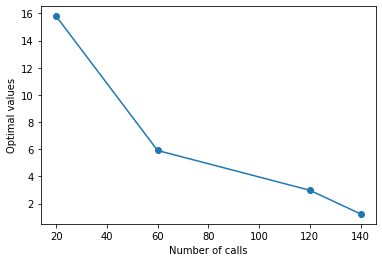

In [61]:
print(values)
plt.plot(calls, values, '-o')
plt.xlabel("Number of calls")
plt.ylabel("Optimal values")
plt.show()